In [1]:
# install sompy (use our forked version - the original one has visualization bugs)
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git

In [2]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

## Import preprocessed data

In [3]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [4]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [5]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x0_2nd Cycle', 'x0_Graduation', 'x0_Master', 'x0_PhD', 'x1_Married',
       'x1_Single', 'x1_Together', 'x1_Widow', 'x2_M', 'x3_1.0',
       'x4_Kind of OK', 'x4_Meh...', 'x4_OK nice!', 'x4_Take my money!!',
       'PC0', 'PC1', 'PC2'],
      dtype='object')

In [6]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## Self-organizing maps
What is a SOM? How does it work? What is it used for?

### How is it computed?
### Important concepts:
- Units and observations
- BMU
- Neighborhood function
- Input and Output space

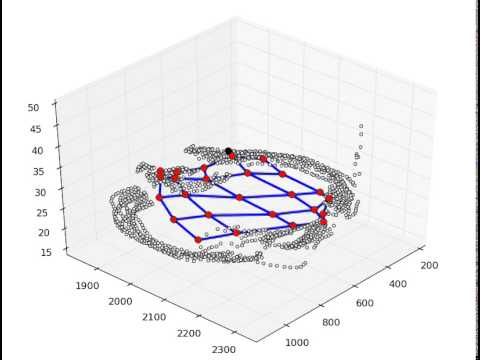

In [7]:
YouTubeVideo('k7DK5fnJH94')

### Characteristics:
- Grid shape needs to be set a priori
- Results depend on the initialization (even tough it can be quite robust to it)
- Fitting a SOM can be computationally expensive
- Capable of finding the global optimum (theoretically - if the LR -> 0)
- Visualization tool for high-dimensional data

### Additional analyses/tutorials
- [Air Flights](https://github.com/sevamoo/SOMPY/blob/master/sompy/examples/AirFlights_hexagonal_grid.ipynb)
- [Visualizations on toy datasets](https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11)

### How to apply Self-Organizing Maps?

The training of a SOM is more effective if it is done in two phases: the unfolding phase, and the fine-tuning phase. 

In the **unfolding phase** the objective is to **spread the units** in the region of the input space where the data patterns are located. In this phase the neighbourhood function should have a large initial radius so that all units have high mobility and the map can quickly cover the input space.

The **fine tuning phase**, as the name implies, is the process of small adjustments in order to **reduce the quantization error**, and centre the units in the areas where the density of patterns is highest. Usually, in this phase the learning rate and the neighbourhood radius are smaller than the ones used in the unfolding phase. As these two parameters are smaller, the map will need more time to adjust its weights and that is why the number of iterations or epochs is normally higher.

In [26]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=(10, 10),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.017000, quantization error: 3.682456

 epoch: 2 ---> elapsed time:  0.021000, quantization error: 2.948670

 epoch: 3 ---> elapsed time:  0.019000, quantization error: 2.864989

 epoch: 4 ---> elapsed time:  0.020000, quantization error: 2.816590

 epoch: 5 ---> elapsed time:  0.020000, quantization error: 2.803051

 epoch: 6 ---> elapsed time:  0.020000, quantization error: 2.793690

 epoch: 7 ---> elapsed time:  0.019000, quantization error: 2.785611

 epoch: 8 ---> elapsed time:  0.022000, quantization error: 2.779075

 epoch: 9 ---> elapsed time:  0.019000, quantization error: 2.771679

 epoch: 10 ---> elapsed time:  0.021000, quantization error: 2.759984

 epoch: 11 ---> elapsed time:  0.019000, quantization error: 2.752625

 epoch: 12 ---> elapsed time:  0.019000, quantization error: 2.747479

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.017000, quantization error: 1.671675

 epoch: 15 ---> elapsed time:  0.019000, quantization error: 1.671554

 epoch: 16 ---> elapsed time:  0.021000, quantization error: 1.671516

 epoch: 17 ---> elapsed time:  0.019000, quantization error: 1.671456

 epoch: 18 ---> elapsed time:  0.018000, quantization error: 1.671412

 epoch: 19 ---> elapsed time:  0.018000, quantization error: 1.671357

 epoch: 20 ---> elapsed time:  0.017000, quantization error: 1.671210

 epoch: 21 ---> elapsed time:  0.016000, quantization error: 1.671143

 epoch: 22 ---> elapsed time:  0.018000, quantization error: 1.671093

 epoch: 23 ---> elapsed time:  0.017000, quantization error: 1.670948

 epoch: 24 ---> elapsed time:  0.017000, quantization error: 1.670793

 epoch: 25 ---> elapsed time:  0.020000, quantization error: 1.670655

 epoch: 26 ---> elapsed time:  0.019000, quantization error: 1.670474

 epoch: 27 ---> elapsed time:  0.018000, quantization error: 1.670214

 epoch

## Visualizing data with SOMs

### Component planes
What do they represent? What kinds of information do they contain?

Analyse these plots from the following perspectives:
- Feature importance
- Feature correlation (both globally and locally)
- Data distribution
- Outlier detection

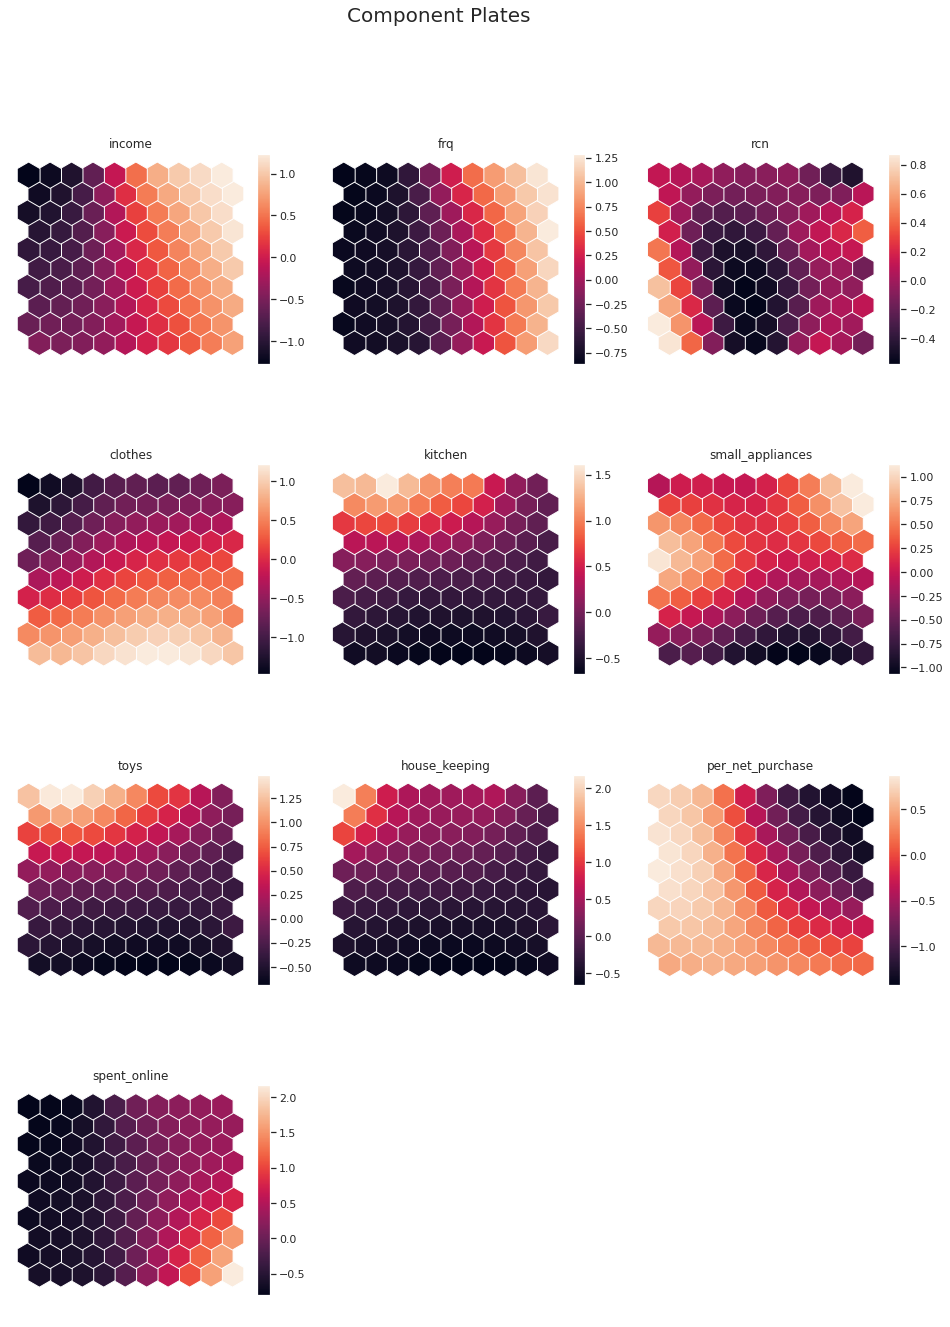

In [29]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

## U-matrix
 Encode each neuron in the output space with the **average distance** to its neighbors in the input space.

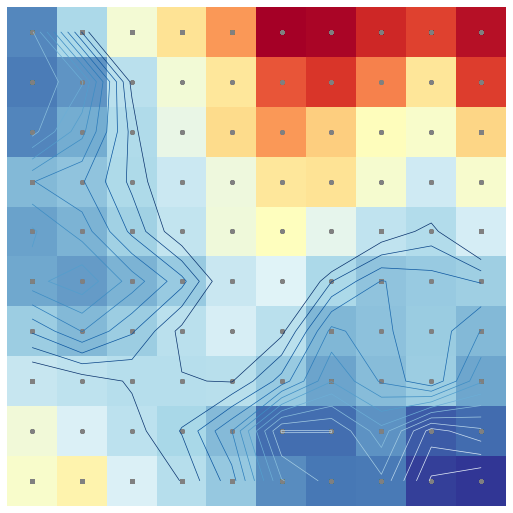

array([[0.3807805 , 0.42401407, 0.46562337, 0.49783963, 0.53464144,
        0.60425246, 0.60122219, 0.58277527, 0.57044928, 0.59421115],
       [0.37585387, 0.38684453, 0.43129978, 0.46463709, 0.49517359,
        0.56190775, 0.57552652, 0.54391153, 0.4960568 , 0.57275518],
       [0.37923406, 0.39771906, 0.4255929 , 0.45696245, 0.50327705,
        0.53510117, 0.51031262, 0.47657259, 0.46974689, 0.50614649],
       [0.40522936, 0.41087325, 0.42508767, 0.43901353, 0.46167542,
        0.4946071 , 0.49793481, 0.46705073, 0.44155234, 0.46821209],
       [0.39267187, 0.40216607, 0.41904227, 0.43511478, 0.46241547,
        0.47529963, 0.45406358, 0.43449919, 0.42701194, 0.44440547],
       [0.39563564, 0.38933477, 0.40215994, 0.41543108, 0.43840005,
        0.44924842, 0.42370291, 0.41120341, 0.41487665, 0.41798896],
       [0.41669535, 0.40533301, 0.41676843, 0.43146186, 0.44559699,
        0.43126595, 0.40370664, 0.41022739, 0.41581005, 0.40526364],
       [0.43741641, 0.43315208, 0.4286157

In [61]:
# Here you have U-matrix plus its render
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)
UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=True, 
    contooor=True, # Visualize isomorphic curves
    blob=False
)

UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values :(

### Hit-map
Show the **frequency** of each Unit in the output map

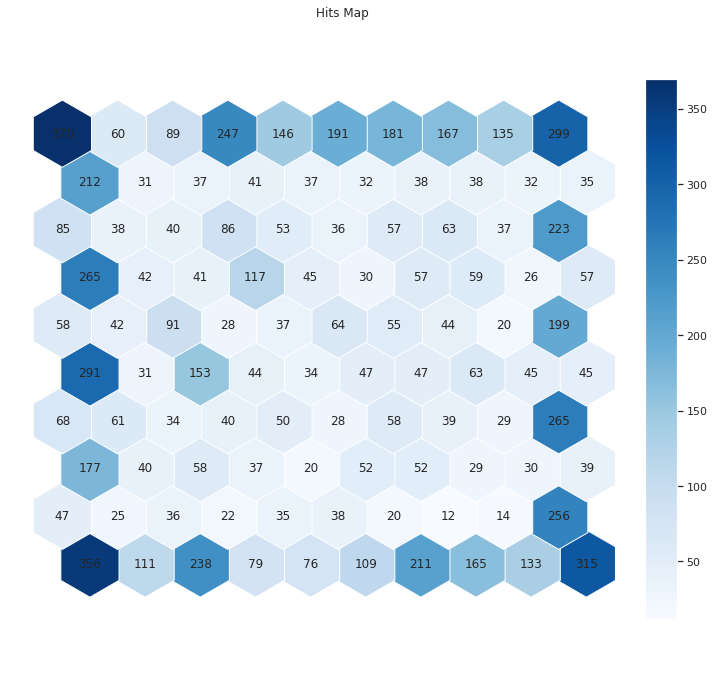

In [65]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

In [66]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.479000, quantization error: 2.528420

 epoch: 2 ---> elapsed time:  0.561000, quantization error: 3.002930

 epoch: 3 ---> elapsed time:  0.503000, quantization error: 2.970614

 epoch: 4 ---> elapsed time:  0.529000, quantization error: 2.958829

 epoch: 5 ---> elapsed time:  0.636000, quantization error: 2.950544

 epoch: 6 ---> elapsed time:  0.549000, quantization error: 2.946090

 epoch: 7 ---> elapsed time:  0.610000, quantization error: 2.941941

 epoch: 8 ---> elapsed time:  0.643000, quantization error: 2.938316

 epoch: 9 ---> elapsed time:  0.563000, quantization error: 2.935348

 epoch: 10 ---> elapsed time:  0.688000, quantization error: 2.933318

 epoch: 11 ---> elapsed time:  0.566000, quantization error: 2.931739

 epoch: 12 ---> elapsed time:  0.610000, quantization error: 2.930186

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.541000, quantization error: 2.084160

 epoch: 15 ---> elapsed time:  0.563000, quantization error: 2.076660

 epoch: 16 ---> elapsed time:  0.511000, quantization error: 2.069108

 epoch: 17 ---> elapsed time:  0.571000, quantization error: 2.061547

 epoch: 18 ---> elapsed time:  0.483000, quantization error: 2.053975

 epoch: 19 ---> elapsed time:  0.598000, quantization error: 2.046389

 epoch: 20 ---> elapsed time:  0.574000, quantization error: 2.038755

 epoch: 21 ---> elapsed time:  0.530000, quantization error: 2.031121

 epoch: 22 ---> elapsed time:  0.576000, quantization error: 2.023451

 epoch: 23 ---> elapsed time:  0.464000, quantization error: 2.015753

 epoch: 24 ---> elapsed time:  0.526000, quantization error: 2.007914

 epoch: 25 ---> elapsed time:  0.634000, quantization error: 2.000030

 epoch: 26 ---> elapsed time:  0.523000, quantization error: 1.992099

 epoch: 27 ---> elapsed time:  0.534000, quantization error: 1.984064

 epoch

In [69]:
# Coordinates of the units in the input space
sm.get_node_vectors()

array([[-0.203886, -0.475204,  1.207962, ..., -0.764257,  0.623648,
        -0.275624],
       [-0.32759 , -0.634773,  1.245997, ..., -0.765059,  0.56922 ,
        -0.460277],
       [-0.434649, -0.826262,  1.290584, ..., -0.76608 ,  0.575378,
        -0.666304],
       ...,
       [ 1.449922,  1.682047, -1.03553 , ..., -0.291692, -1.499424,
         0.52029 ],
       [ 1.506181,  1.819907, -1.106485, ..., -0.177894, -1.426599,
         0.739191],
       [ 1.598038,  1.985389, -1.075974, ...,  0.009185, -1.397343,
         0.905554]])

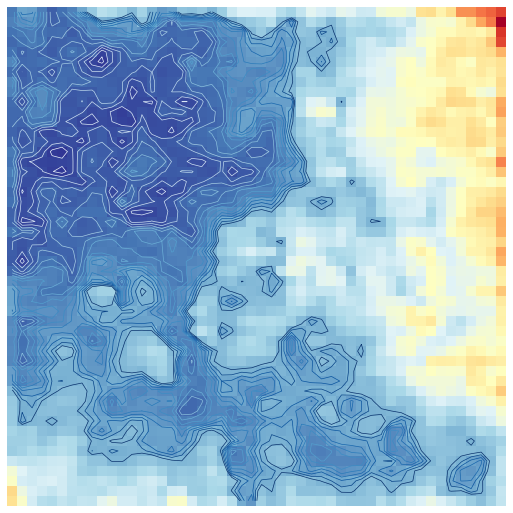

In [74]:
# faz um plt.subplots com os clusters e a u-matrix uma ao lado da outra para melhor interpretação talvez?
# tenta fazer mas não percas muito tempo nisso, pelo que vi no código do sompy para fazer isso da forma
# normal do matplotlib é preciso mudar muita coisa no código deles e já não estava com cabeça

u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

### K-Means on top of SOM units
- Define number of clusters to retain

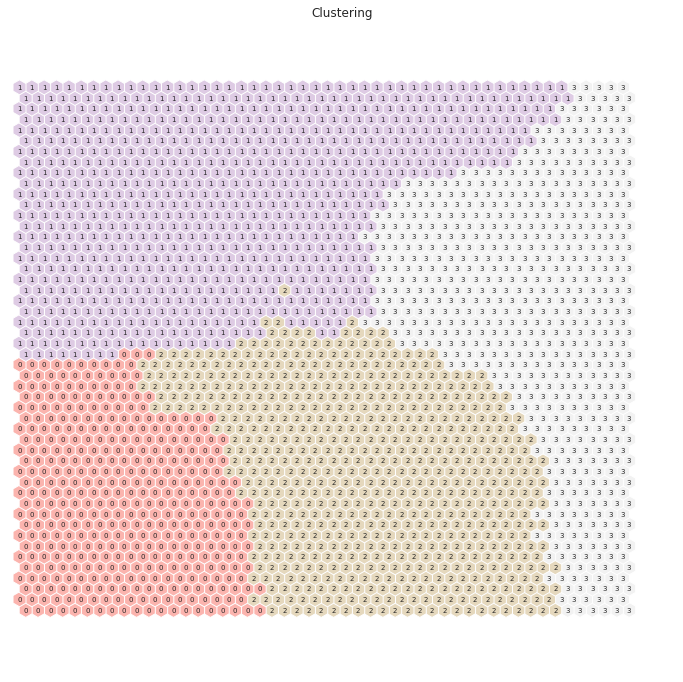

In [76]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

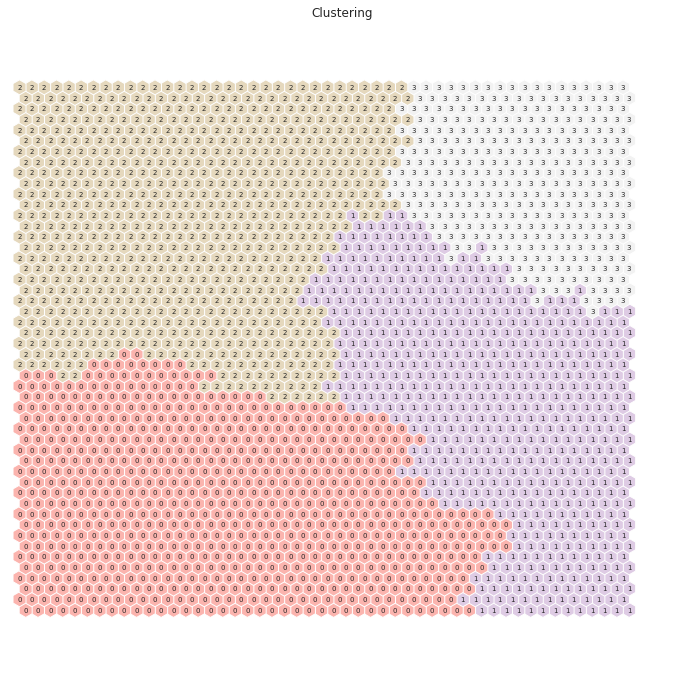

In [77]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Final SOM Clustering solution

In [117]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,label
0,-0.203886,-0.475204,1.207962,1.537326,-0.811625,-1.436793,-0.822923,-0.764257,0.623648,-0.275624,1
1,-0.327590,-0.634773,1.245997,1.509205,-0.803668,-1.391904,-0.811445,-0.765059,0.569220,-0.460277,1
2,-0.434649,-0.826262,1.290584,1.469096,-0.790359,-1.336155,-0.787329,-0.766080,0.575378,-0.666304,1
3,-0.564555,-0.950646,1.343221,1.412958,-0.769808,-1.273118,-0.754146,-0.743961,0.669239,-0.813677,1
4,-0.625880,-0.987809,1.360826,1.294783,-0.741113,-1.097359,-0.735120,-0.723223,0.720631,-0.861203,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,1.193755,1.150964,-0.730309,-0.633931,-0.231936,1.712720,-0.352404,-0.384531,-1.570678,0.119666,2
2496,1.345841,1.466777,-0.887780,-0.635514,-0.246626,1.685584,-0.322507,-0.347336,-1.551853,0.311653,2
2497,1.449922,1.682047,-1.035530,-0.693080,-0.223843,1.721046,-0.280040,-0.291692,-1.499424,0.520290,2
2498,1.506181,1.819907,-1.106485,-0.666078,-0.220846,1.561891,-0.212363,-0.177894,-1.426599,0.739191,2


In [119]:
# Obtaining SOM's BMUs labels
df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(sm._bmu[0],1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2,BMU
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,2241.0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,2323.0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,241.0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,1670.0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,2318.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,2468.0
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,2251.0
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,818.0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,1684.0


In [120]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2,BMU,label
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,2241.0,2
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,2323.0,2
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,241.0,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,1670.0,1
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,2318.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,2468.0,2
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,2251.0,3
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,818.0,0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,1684.0,2


In [121]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
label,,,,,,,,,,,,,,,,,,,,,
0,-1.052852,-0.848176,0.157514,-0.830104,0.575644,0.493703,0.615180,0.587657,0.794212,-0.773046,...,0.007443,0.649795,0.876442,0.333830,0.330108,0.325270,0.001861,-2.215902,-0.203179,-0.153653
1,-0.231983,-0.507309,-0.313634,0.958832,-0.585362,-0.749685,-0.584512,-0.574175,0.325839,-0.329062,...,0.027205,0.636492,0.937148,0.314259,0.312852,0.340994,0.026735,0.561047,-1.592114,0.158133
2,0.958103,0.825893,-0.063148,-0.391132,0.133254,0.515096,0.100991,0.113807,-1.121306,0.255916,...,0.102711,0.642230,0.327606,0.125239,0.129439,0.435662,0.307751,0.736021,1.611124,-0.318188
3,0.590523,0.868469,0.297907,0.877908,-0.469727,-0.781210,-0.486805,-0.473497,0.078293,1.529000,...,0.063814,0.644670,0.805656,0.114576,0.107324,0.451777,0.326323,2.052457,-0.202468,0.659219


## Analysing the appropriateness of our solution

Altera isto da forma que achares mais apropriado, isto foi a primeira coisa que me lembrei

In [21]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df)  # get total sum of squares
ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


0.42442269433440605